In [1]:
!pip install spikingjelly
!pip install tensorboardX


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# from google.colab import files
# uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys
sys.path.insert(0, 'drive/MyDrive/Colab Notebooks/CS 679 Project')

Mounted at /content/drive


In [3]:
import time
import logging
from data_builder import *
import argparse
from utils import *
from prior import *
from posterior import *
from layers import *
from networks_for_VAE import *
from tensorboardX import SummaryWriter
from torch.cuda import amp
from schedulers import *
import random
import os
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch
from tqdm.autonotebook import tqdm

In [4]:
####################################################
# args                                             #
#                                                  #
####################################################
class Args:
    def __init__(self, eval=False, eval_resume='./raw/models', train_resume='./raw/models', batch_size=16, epochs=3, 
                 learning_rate=1e-3, momentum=0.9, weight_decay=4e-5, seed=9, auto_continue=False, display_interval=10, 
                 save_interval=10, dataset_path='./dataset/', train_dir='./fmnist/train', val_dir='./fmnist/val', 
                 tunable_lif=False, amp=False, modeltag='SNN', gate=[0.6, 0.8, 0.6], static_gate=False, static_param=False, 
                 channel_wise=False, softsimple=False, soft_mode=False, t=3, randomgate=False, fmnist=False, celeba=True):
        self.eval = eval
        self.eval_resume = eval_resume
        self.train_resume = train_resume
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.seed = seed
        self.auto_continue = auto_continue
        self.display_interval = display_interval
        self.save_interval = save_interval
        self.dataset_path = dataset_path
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.tunable_lif = tunable_lif
        self.amp = amp
        self.modeltag = modeltag
        self.gate = gate
        self.static_gate = static_gate
        self.static_param = static_param
        self.channel_wise = channel_wise
        self.softsimple = softsimple
        self.soft_mode = soft_mode
        self.t = t
        self.randomgate = randomgate
        self.fmnist = fmnist
        self.celeba = celeba


# Data Builder

In [5]:
def seed_all(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

args = Args(batch_size=100)

seed_all(args.seed)

if torch.cuda.device_count() > 1:
    local_rank = int(os.environ["LOCAL_RANK"])
    torch.distributed.init_process_group(backend="nccl")
    torch.cuda.set_device(local_rank)

# Log
log_format = '[%(asctime)s] %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
    format=log_format, datefmt='%d %I:%M:%S')
t = time.time()
local_time = time.localtime(t)
if not os.path.exists('./log'):
    os.mkdir('./log')
fh = logging.FileHandler(os.path.join('log/train-{}{:02}{}'.format(local_time.tm_year % 2000, local_time.tm_mon, t)))
fh.setFormatter(logging.Formatter(log_format))
logging.getLogger().addHandler(fh)

epochs = 1
initial_dict = {'gate': [0.6, 0.8, 0.6], 'param': [tau, Vth, linear_decay, conduct],
                't': steps, 'static_gate': True, 'static_param': False, 'time_wise': True, 'soft_mode': False}
initial_dict['gate'] = args.gate
initial_dict['static_gate'] = args.static_gate
initial_dict['static_param'] = args.static_param
initial_dict['time_wise'] = False
initial_dict['soft_mode'] = args.soft_mode
if args.t != steps:
    initial_dict['t']=args.t

# In case time step is too large, we intuitively recommend to use the following code to alleviate the linear decay
# initial_dict['param'][2] = initial_dict['param'][1]/(initial_dict['t'] * 2)


use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
if args.fmnist:
    train_loader, val_loader, _ = build_data(dpath=args.dataset_path,dataset='FashionMNIST',
                                              batch_size=args.batch_size, train_val_split=False, workers=2)
else:
    train_loader, val_loader, _ = build_data(dpath=args.dataset_path,dataset='CelebA',
                                              batch_size=args.batch_size, train_val_split=False, workers=2)

print('load data successfully')

print(initial_dict)



Downloading...
From: https://drive.google.com/uc?id=1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ
To: /content/celeba.zip
100%|██████████| 1.31G/1.31G [00:16<00:00, 78.6MB/s]


load data successfully
{'gate': [0.6, 0.8, 0.6], 'param': [0.25, 0.5, 0.0625, 0.5], 't': 3, 'static_gate': False, 'static_param': False, 'time_wise': False, 'soft_mode': False}


# Train & Test 

In [19]:
# def train(args, model, device, train_loader, optimizer, epoch, writer, scaler=None):
#     layer_cnt, gate_score_list = None, None
#     t1 = time.time()
#     train_loss = 0
#     model.train()
#     for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#         data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.long)
#         optimizer.zero_grad()
#         if scaler is not None:
#             with amp.autocast():
#                 output, input, mean, log_variances = model(data)
#                 train_loss = model.loss_function(mean, log_variances, output, input)
#                 total_loss = train_loss['loss']

#         else:
#             output, input, mean, log_variances = model(data)
#             train_loss = model.loss_function(means=mean, log_variances=log_variances, output=output, target=input)
#             total_loss = train_loss['loss']

#         if scaler is not None:
#             scaler.scale(total_loss).backward()
#             scaler.step(optimizer)
#             scaler.update()

#         else:
#             total_loss.backward()
#             optimizer.step()
#     return train_loss


def train(args, model, device, train_loader, optimizer, epoch, writer, scaler=None):
    layer_cnt, gate_score_list = None, None
    t1 = time.time()
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.long)
        optimizer.zero_grad()
        if scaler is not None:
            with amp.autocast():
                output, q_z, p_z, sampled_z = model(data)

                train_loss = model.loss_function(data, output, q_z, p_z)
                total_loss = train_loss['loss']

        else:
            output, q_z, p_z, sampled_z = model(data)

            train_loss = model.loss_function(data, output, q_z, p_z)
            print(train_loss)
            total_loss = train_loss['loss']

        if scaler is not None:
            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:
            total_loss.backward()
            optimizer.step()
    return train_loss


In [20]:
def test(args, model, device, test_loader, epoch, writer, modeltag, dict_params, best= None):
    layer_cnt, gate_score_list = None, None
    test_loss = 0
    model.eval()# inactivate BN
    t1 = time.time()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.long)
            output, input, mean, log_variances = model(data)
            total_loss, recon_loss, kld_loss = model.loss_function(mean, log_variances, output, input)
            test_loss+=total_loss

        record_param(args, model, dict=dict_params, epoch=epoch, modeltag=modeltag)
    average_test_loss = test_loss / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_loss))
    return average_test_loss


# Model


In [45]:

class DIPVAE_GLIF_Bernoulli(nn.Module):
    def __init__(self, lif_param:dict, tunable_lif=False, in_channels=3, hidden_dims=[32, 64, 128, 256, 512], 
                latent_dim=128,
                k = 20,
                kld_weight_corrector = 1e-4):
        super(DIPVAE_GLIF_Bernoulli, self).__init__()
        
        self.choice_param_name = ['alpha', 'beta', 'gamma']
        self.lifcal_param_name = ['tau', 'Vth', 'leak', 'conduct', 'reVth']
        self.T = lif_param['t']
        self.lif_param = lif_param
        self.tunable_lif = tunable_lif
        self.k = k


        self.latent_dim = latent_dim
        self.kld_weight = kld_weight_corrector

        image_channels = in_channels
        modules = []
        is_first_conv = True
        for h_dim in hidden_dims:
            modules.append(
                tdConv(in_channels, out_channels=h_dim, kernel_size= 3, stride= 2, padding  = 1, 
                       bias=True,
                       bn=tdBatchNorm(h_dim),
                       spike=LIFSpike_CW_Mod(h_dim, **self.lif_param),
                       is_first_conv=is_first_conv)
            )
            in_channels = h_dim
            is_first_conv = False

        self.encoder = nn.Sequential(*modules)
        self.before_latent_layer = tdLinear(hidden_dims[-1]*4,
                                            latent_dim,
                                            bias=True,
                                            bn=tdBatchNorm(latent_dim),
                                            spike=None)
        
        self.prior = PriorBernoulliSTBP(lif_param = self.lif_param, k = self.k)
        
        self.posterior = PosteriorBernoulliSTBP(lif_param = self.lif_param, k = self.k)

        # Build Decoder
        modules = []

        self.decoder_input = tdLinear(latent_dim, 
                                        hidden_dims[-1] * 4, 
                                        bias=True,
                                        bn=tdBatchNorm(hidden_dims[-1] * 4),
                                        spike=None)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                tdConvTranspose(hidden_dims[i],
                                    hidden_dims[i + 1],
                                    kernel_size=3,
                                    stride = 2,
                                    padding=1,
                                    output_padding=1,
                                    bias=True,
                                    bn=tdBatchNorm(hidden_dims[i+1]),
                                    spike=LIFSpike_CW_Mod(hidden_dims[i + 1], **self.lif_param))
                )

            
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(tdConvTranspose(hidden_dims[-1],
                                            hidden_dims[-1],
                                            kernel_size=3,
                                            stride=2,
                                            padding=1,
                                            output_padding=1,
                                            bias=True,
                                            bn=tdBatchNorm(hidden_dims[-1]),
                                            spike=LIFSpike_CW_Mod(hidden_dims[-1], **self.lif_param)),
                            tdConvTranspose(hidden_dims[-1], 
                                            out_channels=image_channels,
                                            kernel_size=3, 
                                            padding=1,
                                            bias=True,
                                            bn=None,
                                            spike=None),
                            nn.Tanh())

        self._initialize_weights()
        self.p = 0
        self.membrane_output_layer = MembraneOutputLayer()
        self.psp = PSP()


        print('steps:{}'.format(self.T),
              'init-tau:{}'.format(tau),
              'aa:{}'.format(aa),
              'Vth:{}'.format(Vth)
              )

    def encode(self, input, scheduled = False):
        input = input.unsqueeze(-1).repeat(1, 1, 1, 1,self.T)
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1, end_dim =3)
        latent_x = self.before_latent_layer(result)
        sampled_z, q_z = self.posterior(latent_x)
        p_z = self.prior(sampled_z, scheduled, self.p)
        return sampled_z, q_z, p_z

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2, self.T)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = self.membrane_output_layer(result) 
        return result

    def forward(self, input):
        sampled_z, q_z, p_z = self.encode(input)
        x_recon = self.decode(sampled_z)
        return x_recon, q_z, p_z, sampled_z
    
    def reparameterize(self, means, log_variances):
        std = torch.exp(0.5 * log_variances)
        eps = torch.randn_like(std)
        return eps * std + means


    def loss_function_mmd(self, input, output, q_z, p_z):
        """
        q_z is q(z|x): (N,latent_dim,k,T)
        p_z is p(z): (N,latent_dim,k,T)
        """
        reconstruction_loss = F.mse_loss(output, input)
        q_z_ber = torch.mean(q_z, dim=2) # (N, latent_dim, T)
        p_z_ber = torch.mean(p_z, dim=2) # (N, latent_dim, T)

        #kld_loss = torch.mean((q_z_ber - p_z_ber)**2)
        mmd_loss = torch.mean((self.psp(q_z_ber)-self.psp(p_z_ber))**2)
        loss = reconstruction_loss + mmd_loss
        return {'loss': loss, 'Reconstruction_Loss':reconstruction_loss, 'Distance_Loss': mmd_loss}

    def loss_function(self, target, output, q_z, p_z):
        """
        q_z is q(z|x): (N,latent_dim,k,T)
        p_z is p(z): (N,latent_dim,k,T)
        """
        reconstruction_loss = F.mse_loss(output, target)
        prob_q = torch.mean(q_z, dim=2) # (N, latent_dim, T)
        prob_p = torch.mean(p_z, dim=2) # (N, latent_dim, T)
        print((1-prob_q+1e-2)/(1-prob_p+1e-2))
        print(torch.any(torch.isnan(torch.log((prob_q+1e-2)/(prob_p+1e-2)))))
        kld_loss = prob_q * torch.log((prob_q+1e-2)/(prob_p+1e-2)) + (1-prob_q)*torch.log((1-prob_q+1e-2)/(1-prob_p+1e-2))
        print(torch.any(torch.isnan(kld_loss)))
        kld_loss = torch.mean(torch.sum(kld_loss, dim=(1,2)))
        
        loss = reconstruction_loss + self.kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':reconstruction_loss, 'Distance_Loss': kld_loss}

    def generate(self, x,):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        return self.forward(x)[0]

    def sample(self, num_samples):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        sampled_z = self.prior.sample(num_samples)
        sampled_z = sampled_z.to(device)
        sampled_x = self.decode(sampled_z)
        return sampled_x, sampled_z

    def update_p(self, epoch, max_epoch):
        init_p = 0.1
        last_p = 0.3
        self.p = (last_p-init_p) * epoch / max_epoch + init_p
    
    def randomize_gate(self):
        for name, m in self.named_modules():
            if all([hasattr(m, i) for i in self.choice_param_name]):
                for i in range(len(self.choice_param_name)):
                    setattr(m, self.choice_param_name[i],
                            nn.Parameter(
                                torch.tensor(init_constrain * (np.random.rand(m.plane) - 0.5)
                                             , dtype=torch.float)
                                        )
                            )
                    

    def _initialize_weights(self):
        for name, m in self.named_modules():
            if isinstance(m, nn.Conv2d):
                if 'first' in name:
                    nn.init.normal_(m.weight, 0, 0.01)
                else:
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm, tdBatchNorm)):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.running_mean, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0001)
                nn.init.constant_(m.running_mean, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                  

In [46]:
print(initial_dict)
#prepare the model
if args.fmnist:
    model = VanillaVAE_GLIF(lif_param=initial_dict, in_channels = 1)

elif args.celeba:
    model = DIPVAE_GLIF_Bernoulli(lif_param=initial_dict, in_channels = 3)


else: #cifar10
      model = DIPVAE_GLIF_Bernoulli(lif_param=initial_dict, in_channels = 3)


if args.randomgate:
    randomize_gate(model)
    # model.randomize_gate
    print('randomized gate')

modeltag = args.modeltag
writer = SummaryWriter('./summaries/' + modeltag)

dict_params = create_para_dict(args, model)
# recording the initial GLIF parameters
record_param(args, model, dict=dict_params, epoch=0, modeltag=modeltag)
# classify GLIF-related params
choice_param_name = ['alpha', 'beta', 'gamma']
lifcal_param_name = ['tau', 'Vth', 'leak', 'conduct', 'reVth']
all_params = model.parameters()
lif_params = []
lif_choice_params = []
lif_cal_params = []

for pname, p in model.named_parameters():
    if pname.split('.')[-1] in choice_param_name:
        lif_params.append(p)
        lif_choice_params.append(p)
    elif pname.split('.')[-1] in lifcal_param_name:
        lif_params.append(p)
        lif_cal_params.append(p)
# fetch id
params_id = list(map(id, lif_params))
other_params = list(filter(lambda p: id(p) not in params_id, all_params))
# optimizer & scheduler
if args.tunable_lif:
    init_lr_diff = 10
    optimizer = torch.optim.SGD([
            {'params': other_params},
            {'params': lif_cal_params, "weight_decay": 0.},
            {'params': lif_choice_params, "weight_decay": 0., "lr":args.learning_rate / init_lr_diff}
        ],
            lr=args.learning_rate,
            momentum=0.9,
            weight_decay=args.weight_decay
        )
    scheduler = CosineAnnealingLR_Multi_Params_soft(optimizer,
                                                        T_max=[args.epochs, args.epochs, int(args.epochs)])
else:
    optimizer = torch.optim.Adam([
        {'params': other_params},
        {'params': lif_params, "weight_decay": 0.}
    ],
        lr=args.learning_rate,
        weight_decay=args.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.97)

# criterion = VAELoss(args)
device = torch.device("cuda" if use_gpu else "cpu")
#Distributed computation
# if torch.cuda.is_available():
#     loss_function = criterion.cuda()
# else:
#     loss_function = criterion.cpu()

if args.auto_continue:
    lastest_model = get_model(modeltag)
    if lastest_model is not None:
        checkpoint = torch.load(lastest_model, map_location='cpu')
        epochs = checkpoint['epoch']
        if torch.cuda.device_count() > 1:
            model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
            checkpoint = deletStrmodule(checkpoint)
        model.load_state_dict(checkpoint['state_dict'], strict=True)
        print('load from checkpoint, the epoch is {}'.format(epochs))
        dict_params = read_param(epoch=epochs, modeltag=modeltag)
        for i in range(epochs):
            scheduler.step()
        epochs += 1


best = {'acc': 0., 'epoch': 0}

if args.eval:
    lastest_model = get_model(modeltag, addr=args.eval_resume)
    if lastest_model is not None:
        epochs = -1
        checkpoint = torch.load(lastest_model, map_location='cpu')
        model.load_state_dict(checkpoint['state_dict'], strict=True)
        if torch.cuda.device_count() > 1:
            device = torch.device(local_rank)
            model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
            model = nn.parallel.DistributedDataParallel(model.cuda(), device_ids=[local_rank],
                                                        output_device=local_rank,
                                                        find_unused_parameters=False)
        else:
            model = model.to(device)
        test(args, model, device, val_loader, epochs, writer, criterion=criterion,
              modeltag=modeltag, best=best, dict_params=dict_params)
    else:
        print('no model detected')
    exit(0)


if torch.cuda.device_count() > 1:
    device = torch.device(local_rank)
    model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
    model = nn.parallel.DistributedDataParallel(model.cuda(), device_ids=[local_rank], output_device=local_rank,
                                                find_unused_parameters=False)
else:
    model = model.to(device)


print('the random seed is {}'.format(args.seed))

# amp
if args.amp:
    scaler = amp.GradScaler()
else:
    scaler = None
for t in range(1):
    loss_result = train(args, model, device, train_loader, optimizer, epochs, writer,
          scaler=scaler)
    print('====> Epoch: {} Loss: {}'.format(
          t, loss_result))
    # if t % 1 == 0:
    #     test(args, model, device, val_loader, epochs, writer,
    #           modeltag=modeltag, best=best, dict_params=dict_params)
    # else:
    #     pass
    print('and lr now is {}'.format(scheduler.get_last_lr()))
    scheduler.step()
writer.close()

{'gate': [0.6, 0.8, 0.6], 'param': [0.25, 0.5, 0.0625, 0.5], 't': 3, 'static_gate': False, 'static_param': False, 'time_wise': False, 'soft_mode': False}
steps:3 init-tau:0.25 aa:0.5 Vth:0.5
the random seed is 9


  0%|          | 0/1628 [00:00<?, ?it/s]

tensor([[[ 9.7309e-01,  1.0194e+00,  3.1767e+00],
         [ 1.0178e+00,  8.9018e-01,  1.7112e+00],
         [ 1.0535e+00,  6.9440e-01,  1.8452e+00],
         ...,
         [ 1.0629e+00,  7.2470e-01, -6.7293e+01],
         [ 9.3287e-01,  6.5878e-01, -7.0161e+00],
         [ 8.7569e-01,  6.5873e-01,  1.2912e+00]],

        [[ 6.5648e-01, -2.0361e-01,  2.0375e+00],
         [ 7.0989e-01, -3.9767e-02,  2.6900e-01],
         [ 5.6814e-01,  8.5240e-01, -1.2287e+00],
         ...,
         [ 2.3439e-01, -1.1944e-01, -9.7757e-01],
         [ 3.4701e-01,  5.6726e-01, -4.8808e+00],
         [ 8.8780e-01,  2.8629e-01, -2.7414e+00]],

        [[ 9.8631e-01,  1.0134e+00,  9.3083e-01],
         [ 1.0540e+00,  9.9329e-01,  1.1055e+00],
         [ 1.0008e+00,  1.0592e+00,  1.0472e+00],
         ...,
         [ 1.0385e+00,  1.2549e+00,  1.0030e+00],
         [ 9.3811e-01,  9.9643e-01,  1.0650e+00],
         [ 9.0756e-01,  1.0376e+00,  1.0229e+00]],

        ...,

        [[ 9.2121e-01,  7.4108e-01, -1

KeyboardInterrupt: ignored

# Save & Load Model

In [15]:
torch.save(model.cpu(), 'vae_glif_bernoulli_1_epoch.pt')
model = torch.load('vae_glif_bernoulli_1_epoch.pt').to(device)
model.eval()

DIPVAE_GLIF_Bernoulli(
  (encoder): Sequential(
    (0): tdConv(
      3, 32, kernel_size=(3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0)
      (bn): tdBatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (spike): LIFSpike_CW_Mod()
    )
    (1): tdConv(
      32, 64, kernel_size=(3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0)
      (bn): tdBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (spike): LIFSpike_CW_Mod()
    )
    (2): tdConv(
      64, 128, kernel_size=(3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0)
      (bn): tdBatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (spike): LIFSpike_CW_Mod()
    )
    (3): tdConv(
      128, 256, kernel_size=(3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0)
      (bn): tdBatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (spike): LIFSpike_CW_Mod()
    )
    (4): tdConv(
      256, 512, kernel_size=(3, 3, 1), stride=(

In [16]:
test_input, test_label = next(iter((val_loader)))
test_input = test_input.to(device)
test_label = test_label.to(device)
recons = model.generate(test_input)

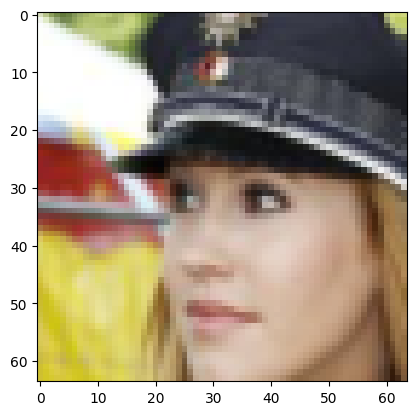

In [17]:
import matplotlib.pyplot as plt
plt.imshow(test_input[0].cpu().detach().permute(1, 2, 0))

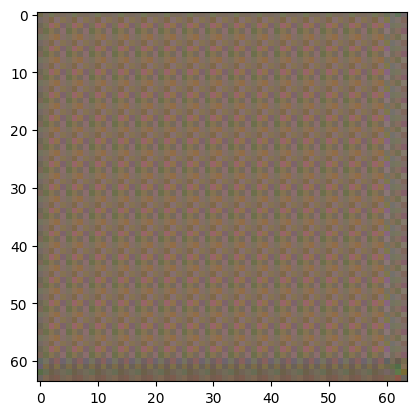

In [18]:
plt.imshow(recons[0].cpu().detach().permute(1, 2, 0))

In [14]:
mu, log_var = model.encode(test_input)
mu[0][0] = mu[0][3] + 0.06
z = model.reparameterize(mu, log_var)
plt.imshow(model.decode(z)[0].cpu().detach().permute(1, 2, 0))

ValueError: ignored

In [ ]:
# new_perp = model.sample(1)
z = torch.randn(1, 128)
z = z.to(device)
samples = model.decode(z)
plt.imshow(  samples[0].cpu().detach().permute(1, 2, 0))

In [ ]:
l_dim = 4
mu, log_var = model.encode(input=test_input)
z = model.reparameterize(mu, log_var)

f, axarr = plt.subplots(1,10, figsize=(30, 30))
count = 0
interpolation = torch.arange(-3., 3.1, 2/3)
for idx, perturbation in enumerate(interpolation):
  orig = z[:,l_dim]
  z[:,l_dim] = perturbation
  axarr[idx].imshow(model.decode(z).mean(0)[0].cpu().detach().permute(1, 2, 0)  )
  z[:,l_dim] = orig

In [ ]:
new_perp = model.sample(1)
plt.imshow(new_perp.mean(0)[0].cpu().detach().permute(1, 2, 0))

In [ ]:
optimizer = torch.optim.Adam([
        {'params': other_params},
        {'params': lif_params, "weight_decay": 0.}
    ],
        lr=1e-4,
        weight_decay=args.weight_decay
    )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.97)

In [ ]:
if args.amp:
    scaler = amp.GradScaler()
else:
    scaler = None
for t in range(1):
    loss_result = train(args, model, device, train_loader, optimizer, epochs, writer,
          scaler=scaler)
    print('====> Epoch: {} Loss: {}'.format(
          t, loss_result))
    # if t % 1 == 0:
    #     test(args, model, device, val_loader, epochs, writer,
    #           modeltag=modeltag, best=best, dict_params=dict_params)
    # else:
    #     pass
    print('and lr now is {}'.format(scheduler.get_last_lr()))
    scheduler.step()
writer.close()

In [ ]:
torch.save(model.cpu(), 'dip_vae_glif_sgd_4_epochs.pt')
# model = torch.load('vae_glif_sgd_3_epochs.pt').to(device)